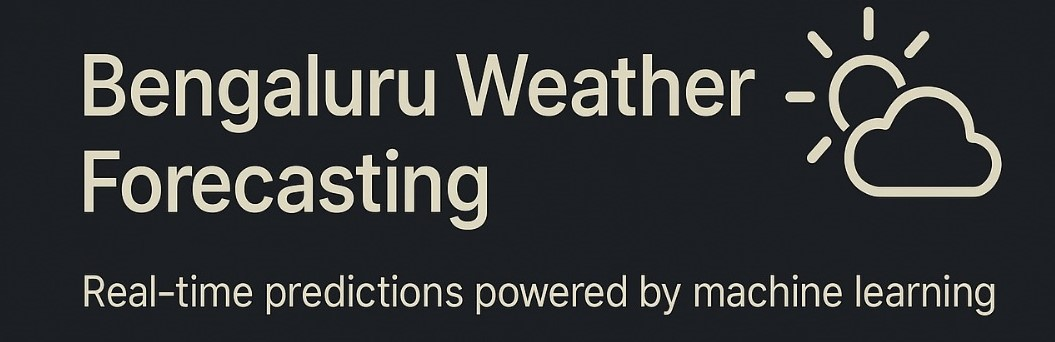

In [1]:
import pandas as pd
import numpy as np

# Read dataset – adjust the path as needed.
df = pd.read_csv("data/hourly_weather.csv", parse_dates=["date_time"])
print(df.head())


# Convert the "date_time" column to a datetime column
df['date_time'] = pd.to_datetime(df['date_time'])

# Split the datetime column into separate columns for year, month, day, and time
df['year'] = df['date_time'].dt.year
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['time'] = df['date_time'].dt.time


# --- Outlier Removal using the IQR Method --- #
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filter rows that are within the bounds
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Remove outliers for columns with high outlier counts
for col in ["temperature", "wind_speed", "pressure", "precipitation"]:
    df = remove_outliers(df, col)

# --- Feature Engineering --- #
# (a) Parse date_time and extract basic features (hour, day of week, month)
df["hour"] = df["date_time"].dt.hour
df["dayofweek"] = df["date_time"].dt.dayofweek  # Monday=0, Sunday=6
# Note: month is already provided, but you can use the datetime column if needed.
# df["month"] = df["date_time"].dt.month

# (b) Create cyclical features for hour and month (to capture periodicity)
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24.0)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24.0)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12.0)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12.0)

# (c) Optionally, encode the weather_condition categorical variable.
# Uncomment if you want to include it as a feature.
# df = pd.get_dummies(df, columns=["weather_condition"], drop_first=True)

            date_time  temperature  humidity  wind_speed  wind_direction  \
0 1990-01-01 00:00:00         19.8      89.0        11.0           109.0   
1 1990-01-01 01:00:00         19.7      89.0        10.4           110.0   
2 1990-01-01 02:00:00         19.3      91.0         8.0           108.0   
3 1990-01-01 03:00:00         19.1      92.0         6.0           107.0   
4 1990-01-01 04:00:00         18.6      95.0         4.9           107.0   

   pressure  precipitation  cloud_coverage weather_condition  
0    1014.8            0.0            88.0          Overcast  
1    1014.5            0.0            75.0     Partly Cloudy  
2    1013.7            0.0            71.0     Partly Cloudy  
3    1013.5            0.0            34.0      Mainly Clear  
4    1013.4            0.0            40.0      Mainly Clear  


In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib
import numpy as np

# Features and targets
target_cols = ["temperature", "humidity", "wind_speed"]
feature_cols = [
    "wind_direction", "pressure", "precipitation", "cloud_coverage",
    "hour_sin", "hour_cos", "month_sin", "month_cos", "dayofweek"
]

X = df[feature_cols]
y = df[target_cols]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define XGBoost regressor
xgb = XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',  # fast & memory-efficient
    n_jobs=-1,
    verbosity=0,
    random_state=42
)

# Wrap with MultiOutputRegressor
multi_output_xgb = MultiOutputRegressor(xgb)

# Build pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", multi_output_xgb)
])

# Define hyperparameter grid
param_grid = {
    "regressor__estimator__n_estimators": [50, 100],
    "regressor__estimator__max_depth": [3, 5, 7],
    "regressor__estimator__learning_rate": [0.05, 0.1],
    "regressor__estimator__subsample": [0.8, 1.0]
}

# Grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring="neg_root_mean_squared_error",
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Best Model RMSE:", rmse)

r2_scores = {col: r2_score(y_test[col], y_pred[:, i]) for i, col in enumerate(target_cols)}
print("R² Scores:", r2_scores)

# Save the best model with compression
joblib.dump(best_model, "xgb_weather_model.pkl")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Model RMSE: 5.414895790344269
R² Scores: {'temperature': 0.9230521676033574, 'humidity': 0.8578467204621777, 'wind_speed': 0.519155573192301}


['xgb_weather_model.pkl']

In [3]:
def retrain_model_job():
    print(f"{pd.Timestamp.now()}: Starting scheduled model update...")
    try:
        # Step 1: Fetch and ingest new data
        os.makedirs("data", exist_ok=True)
        existing_data_path = "data/hourly_weather.csv"
        
        # Determine start_date based on existing data
        start_date = "1990-01-01"
        if os.path.exists(existing_data_path):
            existing_df = pd.read_csv(existing_data_path, parse_dates=["date_time"])
            last_date = existing_df["date_time"].max()
            start_date = (last_date + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
        
        # Set end_date to current date
        end_date = datetime.now().strftime('%Y-%m-%d')
        
        # Skip fetch if start_date > end_date (no new data)
        if start_date > end_date:
            print("No new data to fetch.")
            new_df = existing_df
        else:
            # Fetch new data from API
            latitude = 12.9716
            longitude = 77.5946
            timezone = "auto"
            
            url = "https://archive-api.open-meteo.com/v1/archive"
            params = {
                "latitude": latitude,
                "longitude": longitude,
                "start_date": start_date,
                "end_date": end_date,
                "hourly": "temperature_2m,relative_humidity_2m,wind_speed_10m,wind_direction_10m,pressure_msl,precipitation,cloudcover,weathercode",
                "timezone": timezone
            }
            
            response = requests.get(url, params=params)
            response.raise_for_status()  # Raise error for bad status
            
            data = response.json()
            df = pd.DataFrame(data["hourly"])
            df["date_time"] = pd.to_datetime(df["time"])
            df["weather_condition"] = df["weathercode"].map(weather_map)
            
            # Format and rename columns
            new_df = df[[
                "date_time",
                "temperature_2m",
                "relative_humidity_2m",
                "wind_speed_10m",
                "wind_direction_10m",
                "pressure_msl",
                "precipitation",
                "cloudcover",
                "weather_condition"
            ]].rename(columns={
                "temperature_2m": "temperature",
                "relative_humidity_2m": "humidity",
                "wind_speed_10m": "wind_speed",
                "wind_direction_10m": "wind_direction",
                "pressure_msl": "pressure",
                "cloudcover": "cloud_coverage"
            })
            
            # Merge with existing data
            if os.path.exists(existing_data_path):
                updated_df = pd.concat([existing_df, new_df], ignore_index=True)
                # Remove duplicates and sort
                updated_df = updated_df.drop_duplicates("date_time").sort_values("date_time")
                updated_df.to_csv(existing_data_path, index=False)
                new_df = updated_df
            else:
                new_df.to_csv(existing_data_path, index=False)
        
        # Step 2: Data preprocessing and feature engineering
        # Remove outliers
        for col in ["temperature", "wind_speed", "pressure", "precipitation"]:
            new_df = remove_outliers(new_df, col)
        
        # Feature engineering
        new_df["hour"] = new_df["date_time"].dt.hour
        new_df["dayofweek"] = new_df["date_time"].dt.dayofweek
        new_df["month"] = new_df["date_time"].dt.month
        new_df["hour_sin"] = np.sin(2 * np.pi * new_df["hour"] / 24.0)
        new_df["hour_cos"] = np.cos(2 * np.pi * new_df["hour"] / 24.0)
        new_df["month_sin"] = np.sin(2 * np.pi * new_df["month"] / 12.0)
        new_df["month_cos"] = np.cos(2 * np.pi * new_df["month"] / 12.0)
        
        # Rest of the training pipeline remains the same
        X_new = new_df[feature_cols]
        y_new = new_df[target_cols]
        
        X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
            X_new, y_new, test_size=0.2, random_state=42
        )
        model_pipeline.fit(X_train_new, y_train_new)
        
        y_pred_new = model_pipeline.predict(X_test_new)
        new_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
        print("New model RMSE:", new_rmse)
        
        joblib.dump(model_pipeline, "xgb_weather_model.pkl")
        print("Model retrained and saved successfully.")

    except Exception as e:
        print("Error during model retraining:", e)

In [8]:


# Save this portion in a separate file (e.g., dashboard.py) and run with: streamlit run dashboard.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib

# Load the saved model.
model = joblib.load("xgb_weather_model.pkl")

st.title("Weather Forecasting Dashboard")

st.markdown("### Input the current weather conditions:")

# Sidebar inputs for features.
wind_direction = st.sidebar.slider("Wind Direction", 0.0, 360.0, 180.0)
pressure = st.sidebar.slider("Pressure (hPa)", 1001.0, 1021.0, 1010.0)
precipitation = st.sidebar.slider("Precipitation (mm)", 0.0, 2.0, 0.0)
cloud_coverage = st.sidebar.slider("Cloud Coverage (%)", 0.0, 100.0, 50.0)
hour = st.sidebar.slider("Hour of Day", 0, 23, 12)
dayofweek = st.sidebar.selectbox("Day of the Week (0=Monday)", list(range(7)))
month = st.sidebar.slider("Month", 1, 12, 6)

# Compute the cyclical features.
hour_sin = np.sin(2 * np.pi * hour / 24)
hour_cos = np.cos(2 * np.pi * hour / 24)
month_sin = np.sin(2 * np.pi * month / 12)
month_cos = np.cos(2 * np.pi * month / 12)

# Create the input DataFrame for prediction.
input_features = pd.DataFrame([{
    "wind_direction": wind_direction,
    "pressure": pressure,
    "precipitation": precipitation,
    "cloud_coverage": cloud_coverage,
    "hour_sin": hour_sin,
    "hour_cos": hour_cos,
    "month_sin": month_sin,
    "month_cos": month_cos,
    "dayofweek": dayofweek
}])

st.markdown("### Forecasted Weather Metrics:")
# Get predictions from the model.
predicted = model.predict(input_features)

# The model outputs: [temperature, humidity, wind_speed]
st.write(f"**Temperature:** {predicted[0][0]:.2f} °C")
st.write(f"**Humidity:** {predicted[0][1]:.2f} %")
st.write(f"**Wind Speed:** {predicted[0][2]:.2f} m/s")

Writing WeatherAppXGB.py


In [12]:
# %%script bash --bg
# streamlit run WeatherAppXGB.py

SyntaxError: invalid syntax (2336241102.py, line 2)

In [ ]:
# %%writefile WeatherAppXGB.py

In [ ]:
# %%script bash --bg
# streamlit run WeatherAppXGB.py